In [145]:
import whitebox_workflows as wbw
import matplotlib
import os
from whitebox_workflows import download_sample_data, show
from whitebox_workflows import WbPalette

In [33]:
wbe = wbw.WbEnvironment()
wbe.version()

'Whitebox Workflows for Python v1.3.5 by Whitebox Geospatial Inc. \nDeveloped by Dr. John B. Lindsay, (c) 2022-2024\n\nDescription:\nWhitebox Workflows for Python is an advanced geospatial data analysis platform \nand Python extension module.'

In [42]:
wbe.working_directory = os.getcwd()

wbe.working_directory

'C:\\Users\\NIKHIL\\Downloads\\LiDAR\\'

In [ ]:
lidar = wbe.read_lidar('lidar.laz')

In [55]:
print(f'Number of points in lidar: {lidar.header.number_of_points}')

Number of points in lidar: 39021274


In [56]:
wbe.lidar_info(lidar, output_html_file = 'lidar_info.html')

'Please see output HTML file for result.'

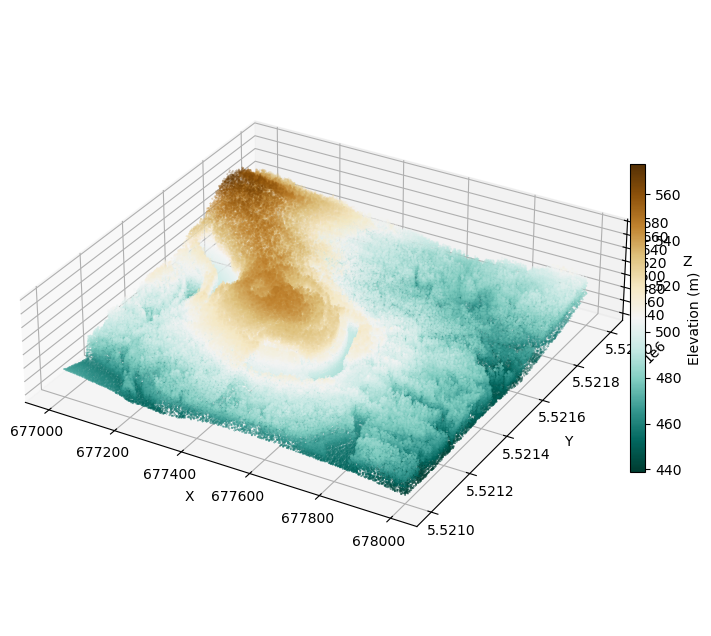

<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>

In [181]:
show(
    lidar,
    figsize = (10, 8),
    skip = 100,
    vert_exaggeration = 2.0,
    marker = 'o',
    s = 0.10,
    cmap = 'BrBG_r',
    colorbar_kwargs = {'location': 'right', 
                       'shrink': 0.5,
                       'label': 'Elevation (m)',
                       'pad': 0.0
                       }
)

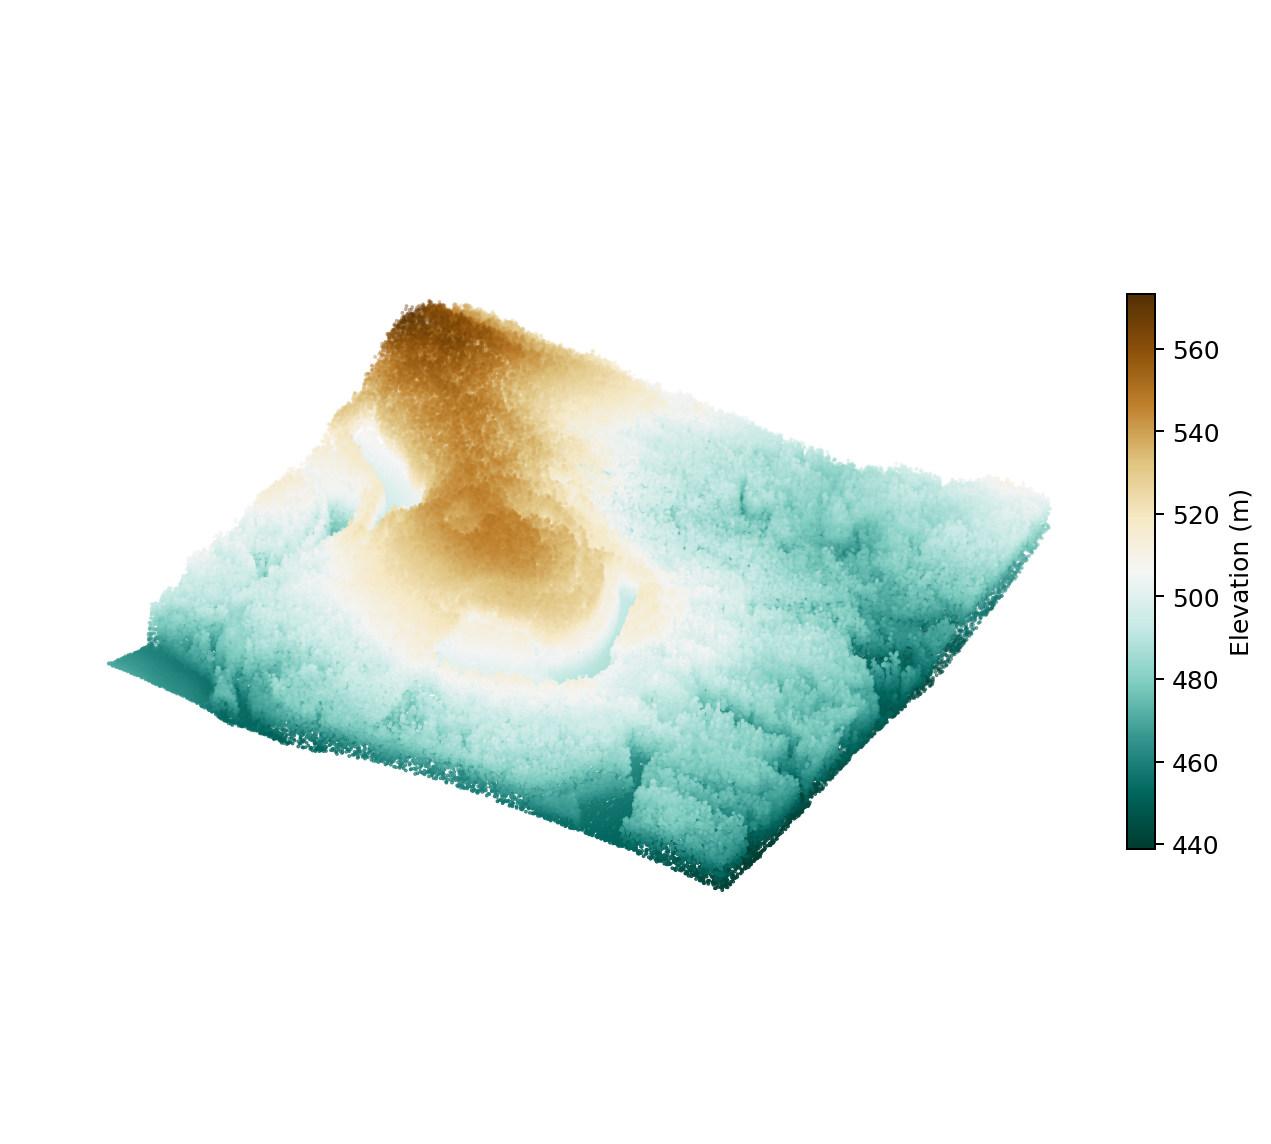

In [180]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_dpi(180.0)
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_axis_off()


show(
    lidar,
    figsize = (10, 8),
    ax = ax,
    skip = 100,
    vert_exaggeration = 2.0,
    marker = 'o',
    s = 0.25,
    cmap = 'BrBG_r',
    colorbar_kwargs = {'location': 'right', 
                       'shrink': 0.5,
                       'label': 'Elevation (m)',
                       'pad': 0.0
                       }
)

plt.show()


In [59]:
dsm = wbe.lidar_digital_surface_model(
    input_lidar = lidar,
    cell_size = 1.0,
    search_radius = 0.5
)

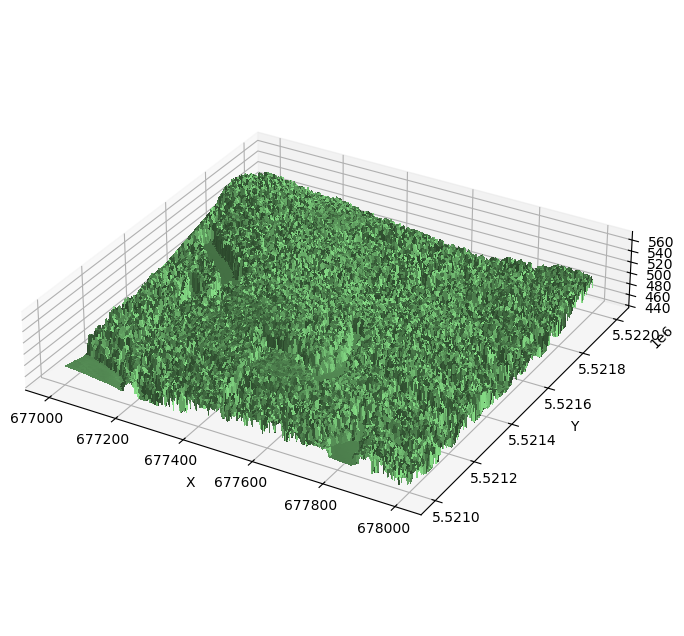

<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>

In [63]:
show(
    dsm, 
    figsize=(10,8),
    skip=2,
    plot_as_surface=True, 
    vert_exaggeration = 1.5,
    color='lightgreen',
    shade=True,
    linewidth=0.0, 
    rcount=175,
    ccount=175,
    antialiased=False
)

In [83]:
wbe.write_raster(dsm, 'DSM.tif', compress = True)

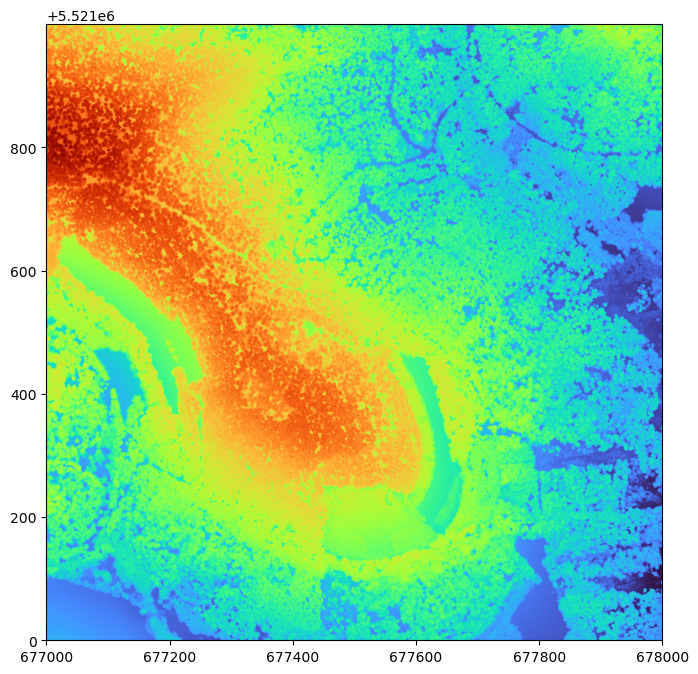

<Axes: >

In [155]:
show(
    dsm,
    figsize = (10, 8),
    cmap = WbPalette.Turbo
)

In [94]:
dem = wbe.lidar_tin_gridding(lidar, 
                            returns_included ='all',
                            cell_size = 1.0, 
                            excluded_classes = [6, 20, 22],              
)

In [82]:
wbe.write_raster(dem, 'DEM.tif')

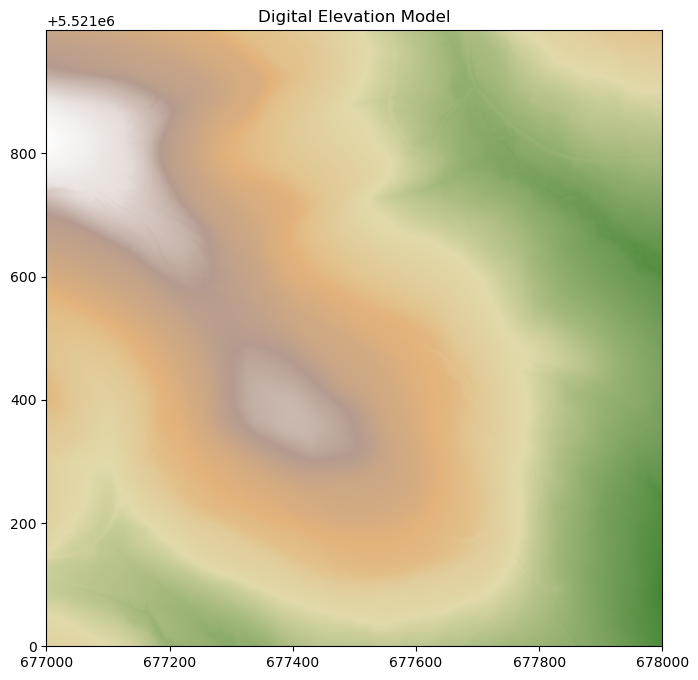

<Axes: title={'center': 'Digital Elevation Model'}>

In [172]:
from whitebox_workflows import WbPalette

show(
    dem, 
    figsize =(10,8),
    cmap = WbPalette.HighRelief, 
    title = 'Digital Elevation Model'
)

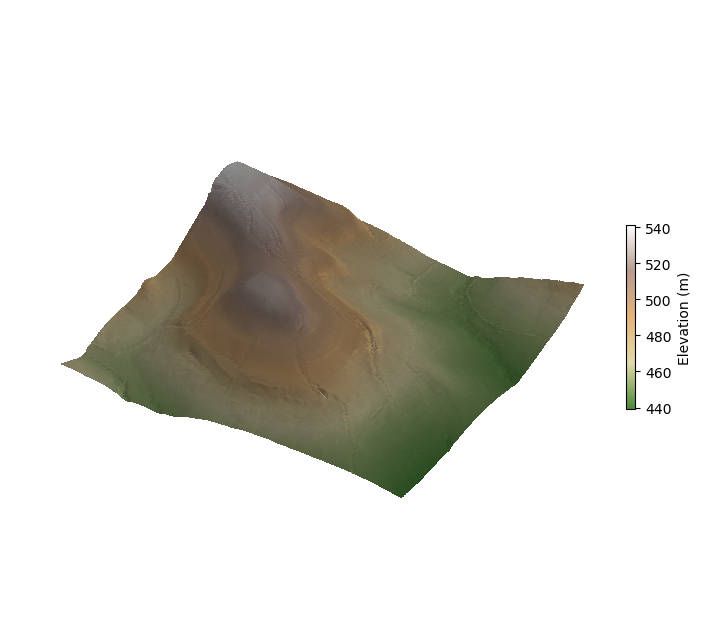

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1 , projection = '3d')

show(
    dem, 
    ax = ax,
    figsize=(10,8),
    skip=2,
    plot_as_surface=True, 
    vert_exaggeration = 2.5,
    cmap = WbPalette.HighRelief,
    shade=True,
    linewidth=0.0, 
    rcount=175,
    ccount=175,
    antialiased=False,
    colorbar_kwargs={'location': 'right',  'shrink': 0.3, 'label': 'Elevation (m)', 'pad': 0.0}
)

ax.set_axis_off()

plt.show()

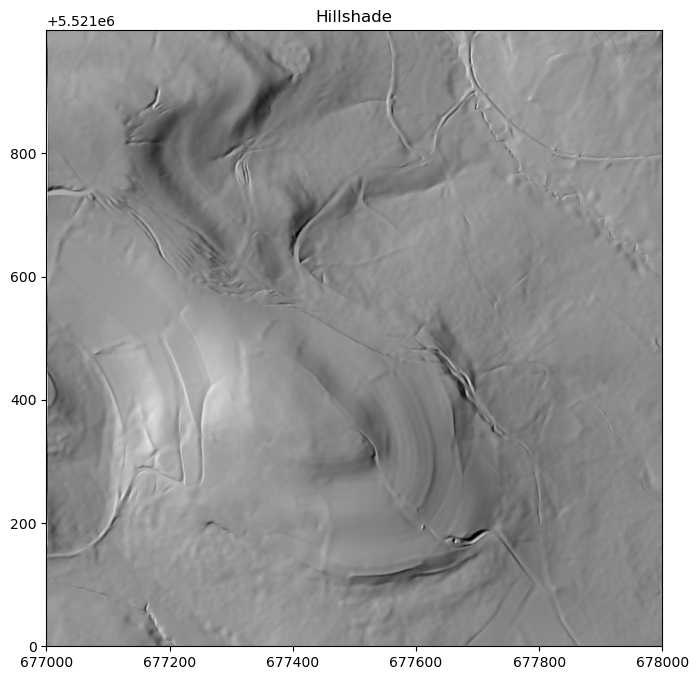

<Axes: title={'center': 'Hillshade'}>

In [179]:
smoothed = wbe.feature_preserving_smoothing(dem, filter_size = 11, 
                                            normal_diff_threshold = 25.0,
                                            iterations = 5)
hs = wbe.multidirectional_hillshade(smoothed)

show(hs, figsize = (10, 8), cmap = WbPalette.Grey, title = 'Hillshade')

In [101]:
wbe.write_raster(hs, 'hillshade.tif', compress = True)

In [105]:
contours = wbe.contours_from_raster(smoothed, contour_interval=10.0)

In [110]:
import math

dem_no_deps = wbe.breach_depressions_least_cost(
    smoothed,
    flat_increment = 0.001,
    max_dist = 100
)

dem_no_deps = wbe.fill_depressions(dem_no_deps, flat_increment = 0.001)

In [140]:
channel_threshold = 10000.0
flow_accum = wbe.qin_flow_accumulation(dem_no_deps,
                                       out_type = 'cells',
                                       convergence_threshold = channel_threshold,
                                       log_transform = True)

In [141]:
streams = flow_accum > math.log(channel_threshold)

In [142]:
d8_pntr = wbe.d8_pointer(dem_no_deps)

In [143]:
streams_vec = wbe.raster_streams_to_vector(streams, d8_pntr)
streams_vec, tmp1, tmp2, tmp3 = wbe.vector_stream_network_analysis(streams_vec, dem_no_deps)
wbe.write_vector(streams_vec, 'streams.shp')

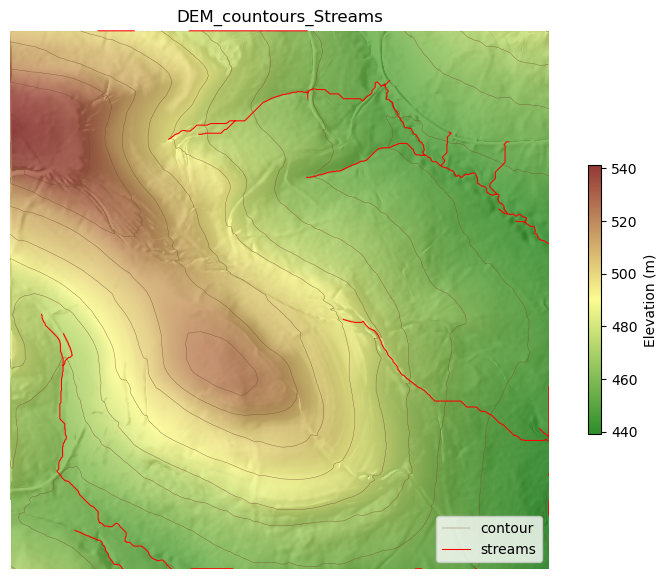

In [185]:
fig, ax = plt.subplots()

ax = show(dem, ax=ax, title='DEM_countours_Streams', cmap=WbPalette.Earthtones, figsize=(10,7), skip=2, colorbar_kwargs={'label': 'Elevation (m)', 'location': "right", 'shrink': 0.5}, zorder=1)
ax = show(hs, ax=ax, cmap='grey', clip_percent=10.0, skip=2, alpha=0.15, zorder=2)
ax = show(contours, ax=ax, color = (0.447, 0.306, 0.173), linewidth=0.25, label='contour', zorder=3)
ax = show(streams_vec, ax=ax, color ='red', linewidth=0.75, label='streams', zorder=5)

ax.set_xlim([dem.configs.west, dem.configs.east])
ax.set_ylim([dem.configs.south, dem.configs.north])

ax.legend() 
ax.set_axis_off()

plt.show()